In [1]:
# 导入包
%matplotlib inline
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

### 3.2.1 生成数据集

构造一个简单的人工训练数据集，样本数为1000，输入特征数为2。

模型的真实权重为`w=[2, -3.4].T`和偏差`b=4.2`，以及一个随机噪声项`ζ`，`y = Xw + b + ζ`

In [7]:
num_inputs = 2
num_samples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_samples, num_inputs, dtype=torch.float32)
print('features.shape', features.shape)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
# labels = true_w * features + true_b
print('labels.shape: ', labels.shape)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float32)

features.shape torch.Size([1000, 2])
labels.shape:  torch.Size([1000])


In [8]:
print(features[0], labels[0])

tensor([ 0.8783, -0.3741]) tensor(7.2255)


通过生成第二特征`features[:, 1]`和标签`labels`的散点图，直观地观察两者间的线性关系。

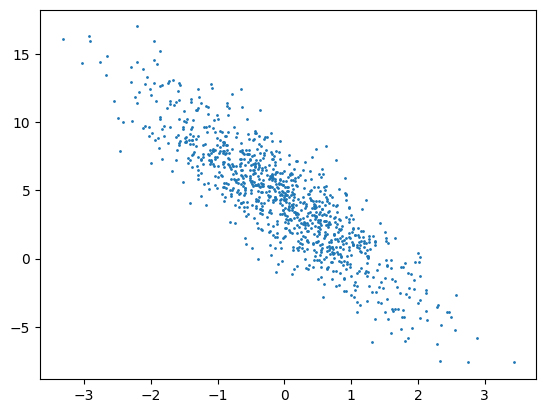

In [10]:
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

### 3.2.2 读取数据

定义一个函数：每次返回`batch_size(批量大小)`个随机样本的特征和标签。

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [11]:
torch.index_select?

Docstring:
index_select(input, dim, index, *, out=None) -> Tensor

Returns a new tensor which indexes the :attr:`input` tensor along dimension
:attr:`dim` using the entries in :attr:`index` which is a `LongTensor`.

The returned tensor has the same number of dimensions as the original tensor
(:attr:`input`).  The :attr:`dim`\ th dimension has the same size as the length
of :attr:`index`; other dimensions have the same size as in the original tensor.

.. note:: The returned tensor does **not** use the same storage as the original
          tensor.  If :attr:`out` has a different shape than expected, we
          silently change it to the correct shape, reallocating the underlying
          storage if necessary.

Args:
    input (Tensor): the input tensor.
    dim (int): the dimension in which we index
    index (IntTensor or LongTensor): the 1-D tensor containing the indices to index

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(3, 4)


In [13]:
batch_size = 16

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.3588,  0.7649],
        [ 1.2605, -1.1513],
        [ 1.7320, -0.8460],
        [ 1.4727,  0.0643],
        [ 0.0817,  1.1468],
        [ 0.7394, -1.5096],
        [-0.1428, -1.8689],
        [ 0.5633, -0.0155],
        [ 0.7553, -0.1486],
        [ 0.6727, -0.4362],
        [ 0.4897,  1.1415],
        [-0.6511,  0.9287],
        [ 0.1198,  1.0282],
        [ 0.5719, -0.0461],
        [ 0.1526,  0.6472],
        [ 0.9252, -0.0668]]) tensor([ 2.2970, 10.6224, 10.5326,  6.9114,  0.4759, 10.8208, 10.2512,  5.3808,
         6.2211,  7.0279,  1.2972, -0.2835,  0.9655,  5.4891,  2.3010,  6.2928])


### 3.2.3 初始化模型参数

将权重初始化为均值为0，标准差为0.01的正态随机数，偏差初始化成0.

In [14]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

之后的模型参数中，需要对这些参数求梯度来迭代参数的值，因此让它们的`requires_grad=True`

In [15]:
w.requires_grad_(True)
b.requires_grad_(True)

tensor([0.], requires_grad=True)

### 3.2.4 定义模型

使用`mm`函数做矩阵乘法

In [16]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

### 3.2.5 定义损失函数

In [17]:
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 3.2.6 定义优化算法

小批量随机梯度下降算法

In [18]:
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

### 3.2.7 训练模型

在每次迭代中，根据当前读取的小批量数据样本(特征`X`和标签`y`)，通过调用反向传播函数`backward()`计算小批量随机梯度，并调用优化算法`sgd`迭代模型参数。

由于之前设批量大小`batch_size`为16，每个小批量的损失`l`的形状为`(10, 1)`。

由于变量`l`并不是一个标量，所以调用`.sum()`将其求和得到一个标量，再运行`l.backward()`得到该变量有关模型参数的梯度。

注意在每次更新完参数后将参数的梯度清零。

In [21]:
lr = 0.03
epochs = 3

for epoch in range(epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = squared_loss(linreg(X, w, b), y).sum()
        l.backward()
        sgd([w, b], lr, batch_size)

        w.grad.data.zero_()
        b.grad.data.zero_()
    train_loss = squared_loss(linreg(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch+1, train_loss.mean().item()))

epoch 1, loss 0.005304
epoch 2, loss 0.000149
epoch 3, loss 0.000052


In [22]:
# 训练后的参数
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9991],
        [-3.3991]], requires_grad=True)
4.2 
 tensor([4.1984], requires_grad=True)
